<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/msambare/fer2013/data

### In this project, I will develop a facial emotion recognition model using the FER2013 dataset. This dataset contains images of human faces, each labeled with one of 7 different emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. The data is already divided into training and testing categories, allowing for efficient model evaluation and performance measurement.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
# upload kaggle's json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"romacarapetean","key":"a46e24d04f7f0717c08d7cd4f8fbb24e"}'}

In [7]:
from IPython.display import clear_output


!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d msambare/fer2013n
!unzip fer2013.zip

clear_output()


Data preprocessing including data augumentaton

I won't add zoom_range and rotation_range because they make emotions less recognizable

In [4]:
train_dir = 'test/'
test_dir = 'train/'

print(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    #zoom_range=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(48, 48),
                                                    batch_size=64, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(48, 48),
                                                    batch_size=64, class_mode='categorical')

['fear', 'disgust', 'happy', 'surprise', 'sad', 'neutral', 'angry']
Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [5]:
num_batches = len(train_generator)
print(f"Number of batches in train_generator: {num_batches}")

Number of batches in train_generator: 113


Why the length of train_generator is only 225 whereas above we can see 'Found 7178 images belonging to 7 classes'. So it is because len function works on a generator object and returns the total number of batches

For a directory with N images and a batch_size of B, the number of batches is aproximately N/B.


7178 / 32 = 224.31

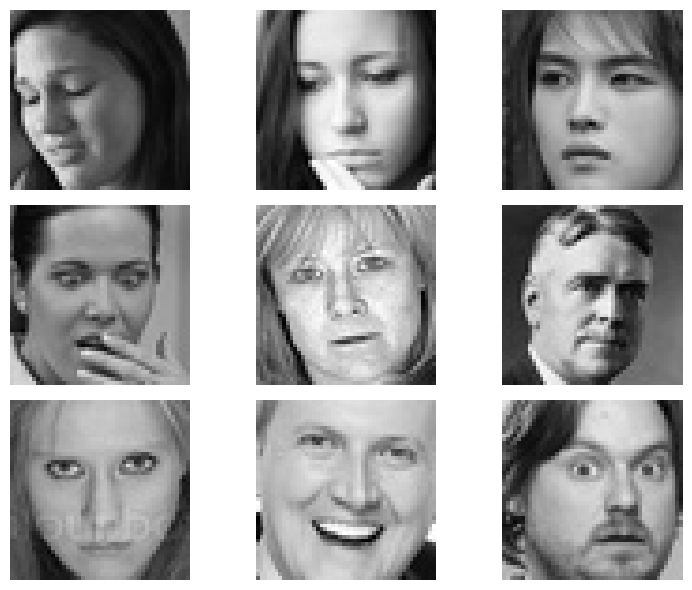

In [6]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))

imgs, labels = next(test_generator)

for i, ax in enumerate(axes.flat):
  if i < len(imgs): # check if we don't exceed the batch size
    ax.imshow(imgs[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

Check the number of channels in the images

In [7]:
batch = next(train_generator)
images, labels = batch

print(images.shape)

(64, 48, 48, 3)


I will try 2 different models

The first one my own and the second one a pretrained model MobileNetV2.

Make the model

I will use residual connection which allows us to slide the gradients through the model to save its weights

The bias term in the layers will be turned off because I will use BatchNormalization which includes its own offset(Beta), making the layer's bias redundant

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

inputs = layers.Input(shape=(48, 48, 3))
x = layers.Conv2D(filters=32, kernel_size=5, activation='relu', use_bias=False,
                  kernel_regularizer=l2(1e-4),)(inputs)

for filters in [32, 64, 128, 256]:
  residual = x # add residual connection

  x = layers.Conv2D(filters, kernel_size=3, padding='same', use_bias=False,
                    kernel_regularizer=l2(1e-4))(x)
  x = LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  x = layers.Dropout(0.25)(x)


  residual = layers.Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [10]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_generator, validation_data=test_generator, epochs=50,
                    callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1614 - loss: 3.0153
Epoch 1: val_accuracy improved from -inf to 0.25121, saving model to model_weights.weights.h5
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.1615 - loss: 3.0145 - val_accuracy: 0.2512 - val_loss: 2.1815 - learning_rate: 1.0000e-04
Epoch 2/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2022 - loss: 2.7017
Epoch 2: val_accuracy improved from 0.25121 to 0.25257, saving model to model_weights.weights.h5
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.2022 - loss: 2.7012 - val_accuracy: 0.2526 - val_loss: 2.2693 - learning_rate: 1.0000e-04
Epoch 3/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2114 - loss: 2.5498
Epoch 3: val_accuracy improved from 0.25257 to 0.25316, saving model to model_weights.weights.h5
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.2114 - loss: 2.5496 - val_accuracy: 0.2532 - val_loss: 2.1827 - learning_rate: 1.0000e-04
Epoch 4/50
112/11

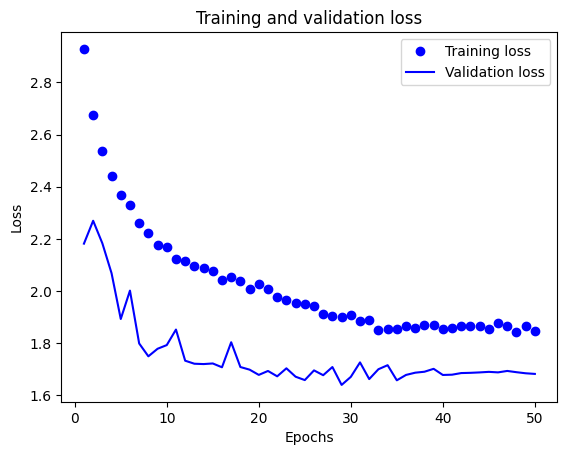

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

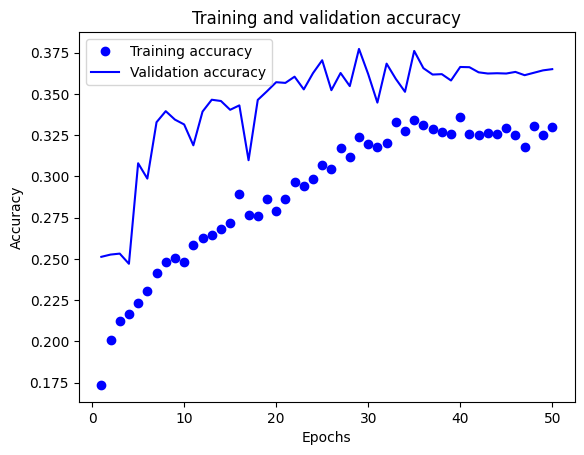

In [12]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trying another approach: a pretrained model MobileNetV2

MobileNetV2 require images to be normalized in range between -1 and 1 so I will implement a new generator

In [13]:
def rescale_to_minusone_one(img):
  return img / 127.5 - 1

train_datagen2 = ImageDataGenerator(
    preprocessing_function=rescale_to_minusone_one,
    #rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    #zoom_range=0.1,
    horizontal_flip=True,
)

train_generator2 = train_datagen2.flow_from_directory(train_dir, target_size=(48, 48),
                                                      batch_size=64, class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [14]:
base_model = keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model2 = keras.Model(inputs=base_model.input, outputs=outputs)

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(train_generator2, validation_data=test_generator, epochs=50)

<ipython-input-14-708ba252c57d>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.2237 - loss: 2.4427 - val_accuracy: 0.2901 - val_loss: 1.9181
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.2595 - loss: 2.0445 - val_accuracy: 0.3106 - val_loss: 1.7902
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.3122 - loss: 1.8564 - val_accuracy: 0.3129 - val_loss: 1.7925
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.3224 - loss: 1.7731 - val_accuracy: 0.3096 - val_loss: 1.8060
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.3373 - loss: 1.7118 - val_accuracy: 0.3244 - val_loss: 1.7322
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.3311 - loss: 1.7037 - val_accuracy: 0.3232 - val_loss: 1.7342
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.3453 - loss: 1.6729 - val_accuracy: 0.3117 - val_loss: 1.7640
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━

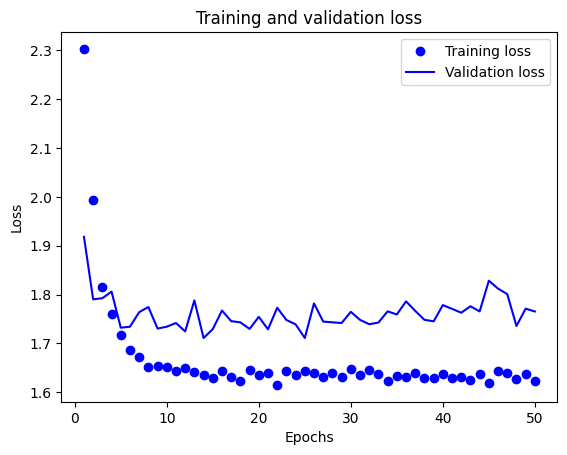

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

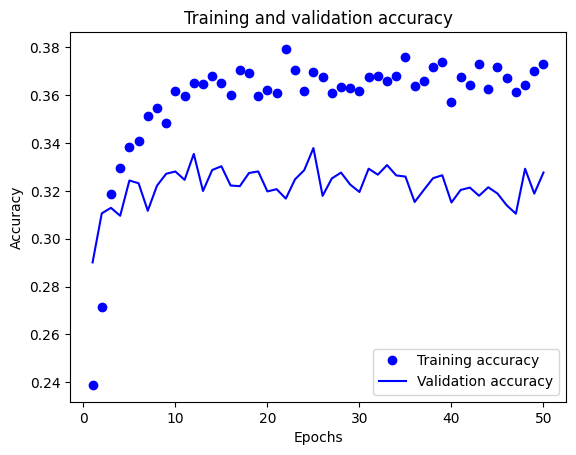

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Saving istockphoto-1388186992-612x612.jpg to istockphoto-1388186992-612x612.jpg


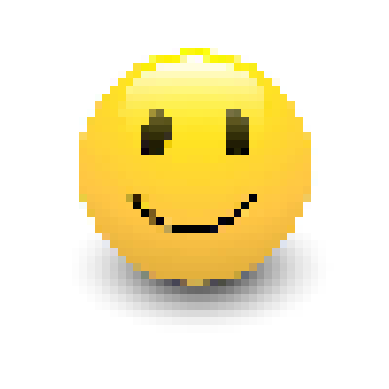

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
Predicted Emotion: Happy


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

# Upload the image
uploaded = files.upload()  # This opens a widget to upload your image

# Assuming only one image is uploaded
image_path = list(uploaded.keys())[0]

# Load the image and display it
img = load_img(image_path, target_size=(48, 48))  # Resize to match your input shape
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocess the image
img_array = img_to_array(img)  # Convert the image to a NumPy array
img_array = img_array / 255.0  # Normalize the pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Get the class with the highest probability

# Map the predicted class to an emotion
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']  # Adjust based on your dataset
predicted_emotion = class_labels[predicted_class]

# Display the result
print(f"Predicted Emotion: {predicted_emotion}")
